In [4]:
from pyproj import Transformer 

In [5]:
transformer = Transformer.from_crs(4326, 3174)
x, y = transformer.transform(80, 70)

In [6]:
transformer.transform(43.067728,-89.412681)

(596853.3445800609, 734093.9318319053)

In [4]:
import pandas as pd
df = pd.DataFrame({'lat':[70,80,90], 'lon':[80,90,100], 'c':[1,2,3]})
for i in range(len(df)):
    x,y = transformer.transform(df.iloc[i]['lat'], df.iloc[i]['lon'])
    df.iloc[i]['lat'] = x
    df.iloc[i]['lon'] = y
df

NameError: name 'transformer' is not defined

In [8]:
from zipfile import ZipFile
with ZipFile("mygtfs.zip") as zf:
    with zf.open("stops.txt") as f:
        data = pd.read_csv(f)
data.at[0, 'stop_lat'] = 20
data

,stop_id,stop_name,stop_lat,stop_lon
0,1,start1,20.000000,-89.412681
1,2,start2,43.070048,-89.409206
2,3,start3,43.073183,-89.409034
3,4,start4,43.073339,-89.400752
4,5,start5,43.073183,-89.394014
5,6,start6,43.076694,-89.389003
6,7,start7,43.087586,-89.373383
7,8,start8,43.094058,-89.362203
8,9,start9,43.100466,-89.354070


In [1]:
from pathlib import Path

import os, sys
from geopy.geocoders import GoogleV3, Nominatim
import geopandas as gpd
import pandas as pd

DIR = Path('..')
sys.path.insert(0, str(DIR))
from SCanalyzer.busSim import BusSim
from SCanalyzer.busSim.manager import LocalManager
from shapely.geometry import Point
from matplotlib.lines import Line2D

manger init
mangager register
mangager register


In [2]:
%matplotlib inline

In [16]:
DATA_PATH = "mygtfs.zip"
OUT_PATH = "/tmp/output"
DAY = "monday"

#FIXME:
#changed start time from 12:00:00 to 05:00:00 to match the stop_times.txt
START_TIME = "04:55:00"
ELAPSE_TIME = "00:50:00"
AVG_WALKING_SPEED = 1.4 # 1.4 meters per second
MAX_WALKING_MIN = 10
city = gpd.read_file("../data/plot/background/madison-shp").to_crs(epsg=4326)
lakes = gpd.read_file("../data/plot/background/water-shp").to_crs(epsg=4326)
street = gpd.read_file("../data/plot/background/street-shp").to_crs(epsg=4326)
max_lon = city.bounds.maxx.max()
min_lon = city.bounds.minx.min()
max_lat = city.bounds.maxy.max()
min_lat = city.bounds.miny.min()

geolocator = Nominatim(user_agent="wisc_bazarr_demo")
manager = LocalManager(DATA_PATH, OUT_PATH)
busSim = BusSim(manager, DAY, START_TIME, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN)

lat = 43.067728, lon = -89.412681
x = 596853.3445800609, y = 734093.9318319053
lat = 43.070048, lon = -89.409206
x = 597151.50524057, y = 734333.9685289594
lat = 43.073183, lon = -89.409034
x = 597186.9416897877, y = 734681.0107380626
lat = 43.073339, lon = -89.400752
x = 597860.6976377999, y = 734656.8532963088
lat = 43.073183, lon = -89.394014
x = 598406.9155881861, y = 734605.8538580168
lat = 43.076694, lon = -89.389003
x = 598837.8714733012, y = 734970.4682981265
lat = 43.087586, lon = -89.373383
x = 600180.5655963306, y = 736101.4106454069
lat = 43.094058, lon = -89.362203
x = 601132.3392748707, y = 736764.1265189559
lat = 43.100466, lon = -89.35407
x = 601836.1061809659, y = 737434.9709751923
new Stops df    stop_id stop_name       stop_lat       stop_lon
0        1    start1  596853.344580  734093.931832
1        2    start2  597151.505241  734333.968529
2        3    start3  597186.941690  734681.010738
3        4    start4  597860.697638  734656.853296
4        5    start5  59

In [17]:
cache = {}
def geocode(addr):
    if not "madison" in addr.lower():
        addr += ", Madison WI"
    if not addr in cache:
        cache[addr] = geolocator.geocode(addr)
    return cache[addr]

In [18]:
def flatten(s):
    return gpd.GeoDataFrame({"geometry": gpd.GeoSeries([s.unary_union])})

In [19]:
def plot(starts=[]):      
    ax = lakes.boundary.plot(color="lightblue", zorder=1, linewidth=2, figsize=(16, 16))
    lakes.plot(color="lightblue", ax=ax, alpha=0.2, zorder=1)
    city.plot(color="black", alpha=0.05, ax=ax, zorder=2)
    street.plot(color="black", alpha=0.03, ax=ax, zorder=3)

    leg_lines = []
    leg_text = []
    
    colors = ["orange", "blue", "green", "yellow"]
    
    zorder = 4
    
    bubbles = []
    for i, addr in enumerate(starts):
        print(addr)
        zorder += 10
        location = geocode(addr)
        lat, lon = (location.latitude, location.longitude)
        # check if the point is indeed in Madison
        if lat > max_lat or lat < min_lat or lon > max_lon or lon < min_lon:
            print(lat, lon)
            print(f"Looks like {start} is not in madison.")
            continue
        # gdf = busSim.get_gdf()
        gdf = busSim.get_gdf(start_point=(lat, lon))
        if gdf is None:
            print(f'illegal start {addr}')
            continue
        gdf = gdf.to_crs(epsg=4326)
        
        color = colors[i % len(colors)]
        bubble = flatten(gdf.difference(lakes.unary_union))
        bubble["color"] = color
        bubbles.append(bubble)
        bubble.boundary.plot(color=color, ax=ax, linewidth=2, zorder=zorder+2)
        gdf["geometry"].centroid.plot(color="black", ax=ax, markersize=2, zorder=zorder+3)
        start = gpd.GeoSeries([Point(lon, lat)])
        start.plot(ax = ax, marker='o', color="black", markersize=160, zorder=100)
        
        leg_lines.append(Line2D([0], [0], color=color, lw=4))
        leg_text.append(addr)
        
    df = pd.concat(bubbles)
    df.plot(alpha=0.2, ax=ax, color=df["color"], zorder=zorder)

    leg = ax.legend(leg_lines, leg_text, prop={"size": 18}, loc="upper left")
    leg.get_frame().set_facecolor("white")
    leg.get_frame().set_edgecolor("white")

    ax.set_axis_off()
    
def demo(addrs_str):
    plot([s.strip() for s in addrs_str.split("\n") if s.strip() != ""])

330 N Orchard St
start.arrival_time=Timedelta('0 days 04:55:00') end.arrival_time=Timedelta('0 days 05:00:00')
distance=679.1179295975797
time_delta=datetime.timedelta(seconds=485, microseconds=84235)
start.arrival_time=Timedelta('0 days 04:55:00') end.arrival_time=Timedelta('0 days 05:00:00')
distance=5361.365466039464
time_delta=datetime.timedelta(seconds=3829, microseconds=546761)
start.arrival_time=Timedelta('0 days 04:55:00') end.arrival_time=Timedelta('0 days 05:10:00')
distance=321.14367616838535
time_delta=datetime.timedelta(seconds=229, microseconds=388340)
start.arrival_time=Timedelta('0 days 04:55:00') end.arrival_time=Timedelta('0 days 05:10:00')
distance=4415.57441402922
time_delta=datetime.timedelta(seconds=3153, microseconds=981724)
start.arrival_time=Timedelta('0 days 04:55:00') end.arrival_time=Timedelta('0 days 05:20:00')
distance=90.0301620876027
time_delta=datetime.timedelta(seconds=64, microseconds=307259)
start.arrival_time=Timedelta('0 days 04:55:00') end.arrival

/tmp/ipykernel_1836/2596569960.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["geometry"].centroid.plot(color="black", ax=ax, markersize=2, zorder=zorder+3)


Camp Randall
start.arrival_time=Timedelta('0 days 04:55:00') end.arrival_time=Timedelta('0 days 05:00:00')
distance=269.00369025726593
time_delta=datetime.timedelta(seconds=192, microseconds=145493)
start.arrival_time=Timedelta('0 days 04:55:00') end.arrival_time=Timedelta('0 days 05:00:00')
distance=5790.080183413607
time_delta=datetime.timedelta(seconds=4135, microseconds=771560)
start.arrival_time=Timedelta('0 days 04:55:00') end.arrival_time=Timedelta('0 days 05:10:00')
distance=215.63186732314134
time_delta=datetime.timedelta(seconds=154, microseconds=22762)
start.arrival_time=Timedelta('0 days 04:55:00') end.arrival_time=Timedelta('0 days 05:10:00')
distance=4840.924402175442
time_delta=datetime.timedelta(seconds=3457, microseconds=803144)
start.arrival_time=Timedelta('0 days 04:55:00') end.arrival_time=Timedelta('0 days 05:20:00')
distance=415.28451679666614
time_delta=datetime.timedelta(seconds=296, microseconds=631798)
start.arrival_time=Timedelta('0 days 04:55:00') end.arriva

/tmp/ipykernel_1836/2596569960.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["geometry"].centroid.plot(color="black", ax=ax, markersize=2, zorder=zorder+3)


Tenney Park
start.arrival_time=Timedelta('0 days 04:55:00') end.arrival_time=Timedelta('0 days 05:00:00')
distance=4497.926870859668
time_delta=datetime.timedelta(seconds=3212, microseconds=804908)
start.arrival_time=Timedelta('0 days 04:55:00') end.arrival_time=Timedelta('0 days 05:00:00')
distance=1508.9543128614393
time_delta=datetime.timedelta(seconds=1077, microseconds=824509)
start.arrival_time=Timedelta('0 days 04:55:00') end.arrival_time=Timedelta('0 days 05:10:00')
distance=4115.851696377828
time_delta=datetime.timedelta(seconds=2939, microseconds=894069)
start.arrival_time=Timedelta('0 days 04:55:00') end.arrival_time=Timedelta('0 days 05:10:00')
distance=620.6689075742282
time_delta=datetime.timedelta(seconds=443, microseconds=334934)
start.arrival_time=Timedelta('0 days 04:55:00') end.arrival_time=Timedelta('0 days 05:20:00')
distance=3895.6930723311702
time_delta=datetime.timedelta(seconds=2782, microseconds=637909)
start.arrival_time=Timedelta('0 days 04:55:00') end.arriv

/tmp/ipykernel_1836/2596569960.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["geometry"].centroid.plot(color="black", ax=ax, markersize=2, zorder=zorder+3)


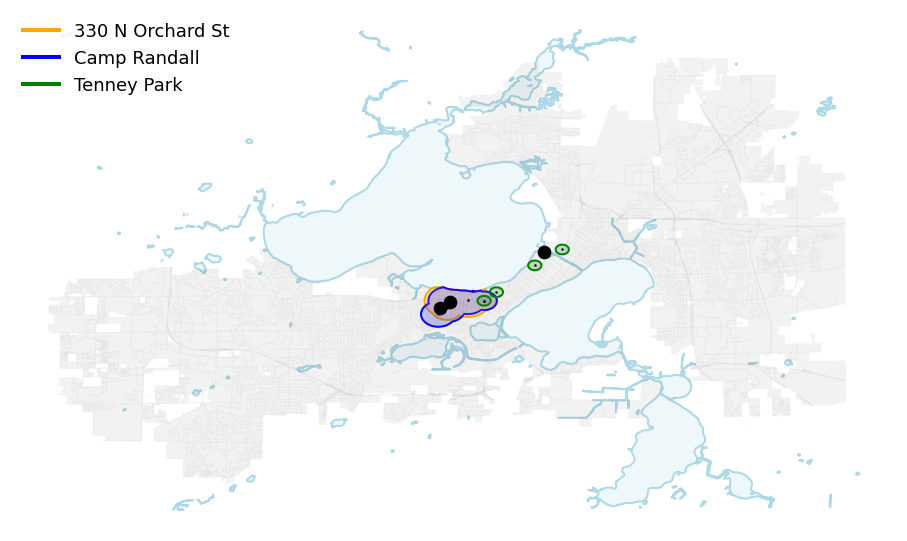

In [23]:
demo("""
330 N Orchard St
Camp Randall
Tenney Park
""")

In [ ]:
list(enumerate(['a','b','c']))

[(0, 'a'), (1, 'b'), (2, 'c')]